In [1]:
# prompt: Need help in deriving PCA for a dataset. I need sample code. Also, I would like to use the dataset LuFlow which is available in my Google Drive. I think I need to do data engineering on the dataset. Can you give the step by step example and the code accordingly?
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import seaborn as sns


In [75]:
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

In [2]:
from sklearn.linear_model import LogisticRegression

In [3]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
%load_ext tensorboard

In [4]:
### To check whether GPU is used.
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU is available and being used.")
    print("GPU Details:", gpu_available)
else:
    print("GPU is not available. Using CPU.")

GPU is not available. Using CPU.


In [5]:
# prompt: how to find the cpu and memory allocated to this google colab notebook? Can you suggest a code to find the details?

# Get system information
!lscpu
!free -h

# Check for hardware acceleration (GPU/TPU)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except:
  tpu = None

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("Running on TPU")
elif tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.get_strategy() # Default strategy for GPU and CPU
  print("Running on GPU")
else:
  strategy = tf.distribute.get_strategy() # Default strategy for CPU
  print("Running on CPU")

print("Number of accelerators: ", strategy.num_replicas_in_sync)


Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4399.99
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt
                           aes xsave avx f16c rdrand hypervisor 

In [6]:
from IPython.display import Image
import os, datetime

In [7]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report,roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [53]:
# Define the file paths in Google Drive
#file_parquet_prepro = '/content/drive/MyDrive/VIT/Dataset/NF-ToN-IoT-v2/nf_ton_iotv2-preprocessed.csv'
file_1 = '/content/drive/MyDrive/VIT/Dataset/UNSW_NB15/UNSW-NB15_training-set.csv'
file_2 = '/content/drive/MyDrive/VIT/Dataset/UNSW_NB15/UNSW-NB15_training-set.csv'

# Read the CSV files back into pandas DataFrames
df1 = pd.read_csv(file_1)
df2 = pd.read_csv(file_2)

# Concatenate the DataFrames
df = pd.concat([df1, df2], ignore_index=True)

# Optional: Display the first few rows and shape to verify they are loaded correctly
print("First 5 rows:")
print(df.head())
print("\nShape:")
print(df.shape)

First 5 rows:
   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  \
0       

In [62]:
# Access the dtypes attribute
feature_data_types = df.dtypes

# Print the data types
print("Data Types of Features:")
print(feature_data_types)

Data Types of Features:
id                     int64
dur                  float64
proto                 object
service               object
state                 object
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl           int64
ct_dst_ltm         

In [55]:
#Get the counts of each unique label
label_counts = df['label'].value_counts()

#Print the results

print("\nCounts of Each Label:")
print(label_counts)


Counts of Each Label:
label
1    238682
0    112000
Name: count, dtype: int64


In [57]:
df = shuffle(df)

In [60]:
def dropInfNull(df):
    print (df.shape)

    # replace infinity value as null value
    df = df.replace(["Infinity", "infinity"], np.inf)
    df = df.replace([np.inf, -np.inf], np.nan)

    # drop all null values
    df.dropna(inplace=True)

    print ("Shape after dropInfNull:", df.shape)

    # --- Added checks after the function runs ---
    if df.isnull().sum().sum() > 0:
        print("WARNING: NaNs found in DataFrame after dropInfNull.")
        print("NaNs per column:\n", df.isnull().sum()[df.isnull().sum() > 0])

    # Check for infinities only in numeric columns
    numeric_df = df.select_dtypes(include=np.number)

    if np.isinf(numeric_df).sum().sum() > 0:
         print("WARNING: Infinities found in DataFrame after dropInfNull in numeric columns.")
         # np.isinf returns boolean array, sum along axes or flatten for total
         inf_counts = np.isinf(numeric_df).sum()
         print("Infinities per column:\n", inf_counts[inf_counts > 0])
    # --- End added checks ---

    return df

In [61]:
%%time
df = dropInfNull(df)

(350682, 45)
Shape after dropInfNull: (350682, 45)
CPU times: user 774 ms, sys: 297 ms, total: 1.07 s
Wall time: 1.06 s


In [63]:
convert_columns = list(df.select_dtypes(include=['category','object']).columns)
convert_columns

['proto', 'service', 'state', 'attack_cat']

In [64]:
# initialize LabelEncoder
label_encoder = LabelEncoder()

# convert
for column in convert_columns:
    df[column] = label_encoder.fit_transform(df[column])

<class 'pandas.core.frame.DataFrame'>
Index: 350682 entries, 200151 to 315369
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 350682 non-null  int64  
 1   dur                350682 non-null  float64
 2   proto              350682 non-null  int64  
 3   service            350682 non-null  int64  
 4   state              350682 non-null  int64  
 5   spkts              350682 non-null  int64  
 6   dpkts              350682 non-null  int64  
 7   sbytes             350682 non-null  int64  
 8   dbytes             350682 non-null  int64  
 9   rate               350682 non-null  float64
 10  sttl               350682 non-null  int64  
 11  dttl               350682 non-null  int64  
 12  sload              350682 non-null  float64
 13  dload              350682 non-null  float64
 14  sloss              350682 non-null  int64  
 15  dloss              350682 non-null  int64  
 16  si

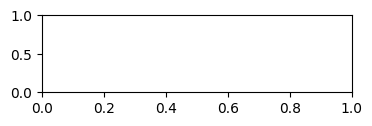

In [66]:
df.info()

In [67]:
%%time
# drop the constant columns (which varience is 0)
variances = df_balanced.var(numeric_only=True)
constant_columns = variances[variances == 0].index
df_balanced = df_balanced.drop(constant_columns, axis=1)

print(constant_columns)
print (df_balanced.shape)

Index([], dtype='object')
(722130, 38)
CPU times: user 572 ms, sys: 93 ms, total: 665 ms
Wall time: 661 ms


/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


**Drop Columns based on correlation**

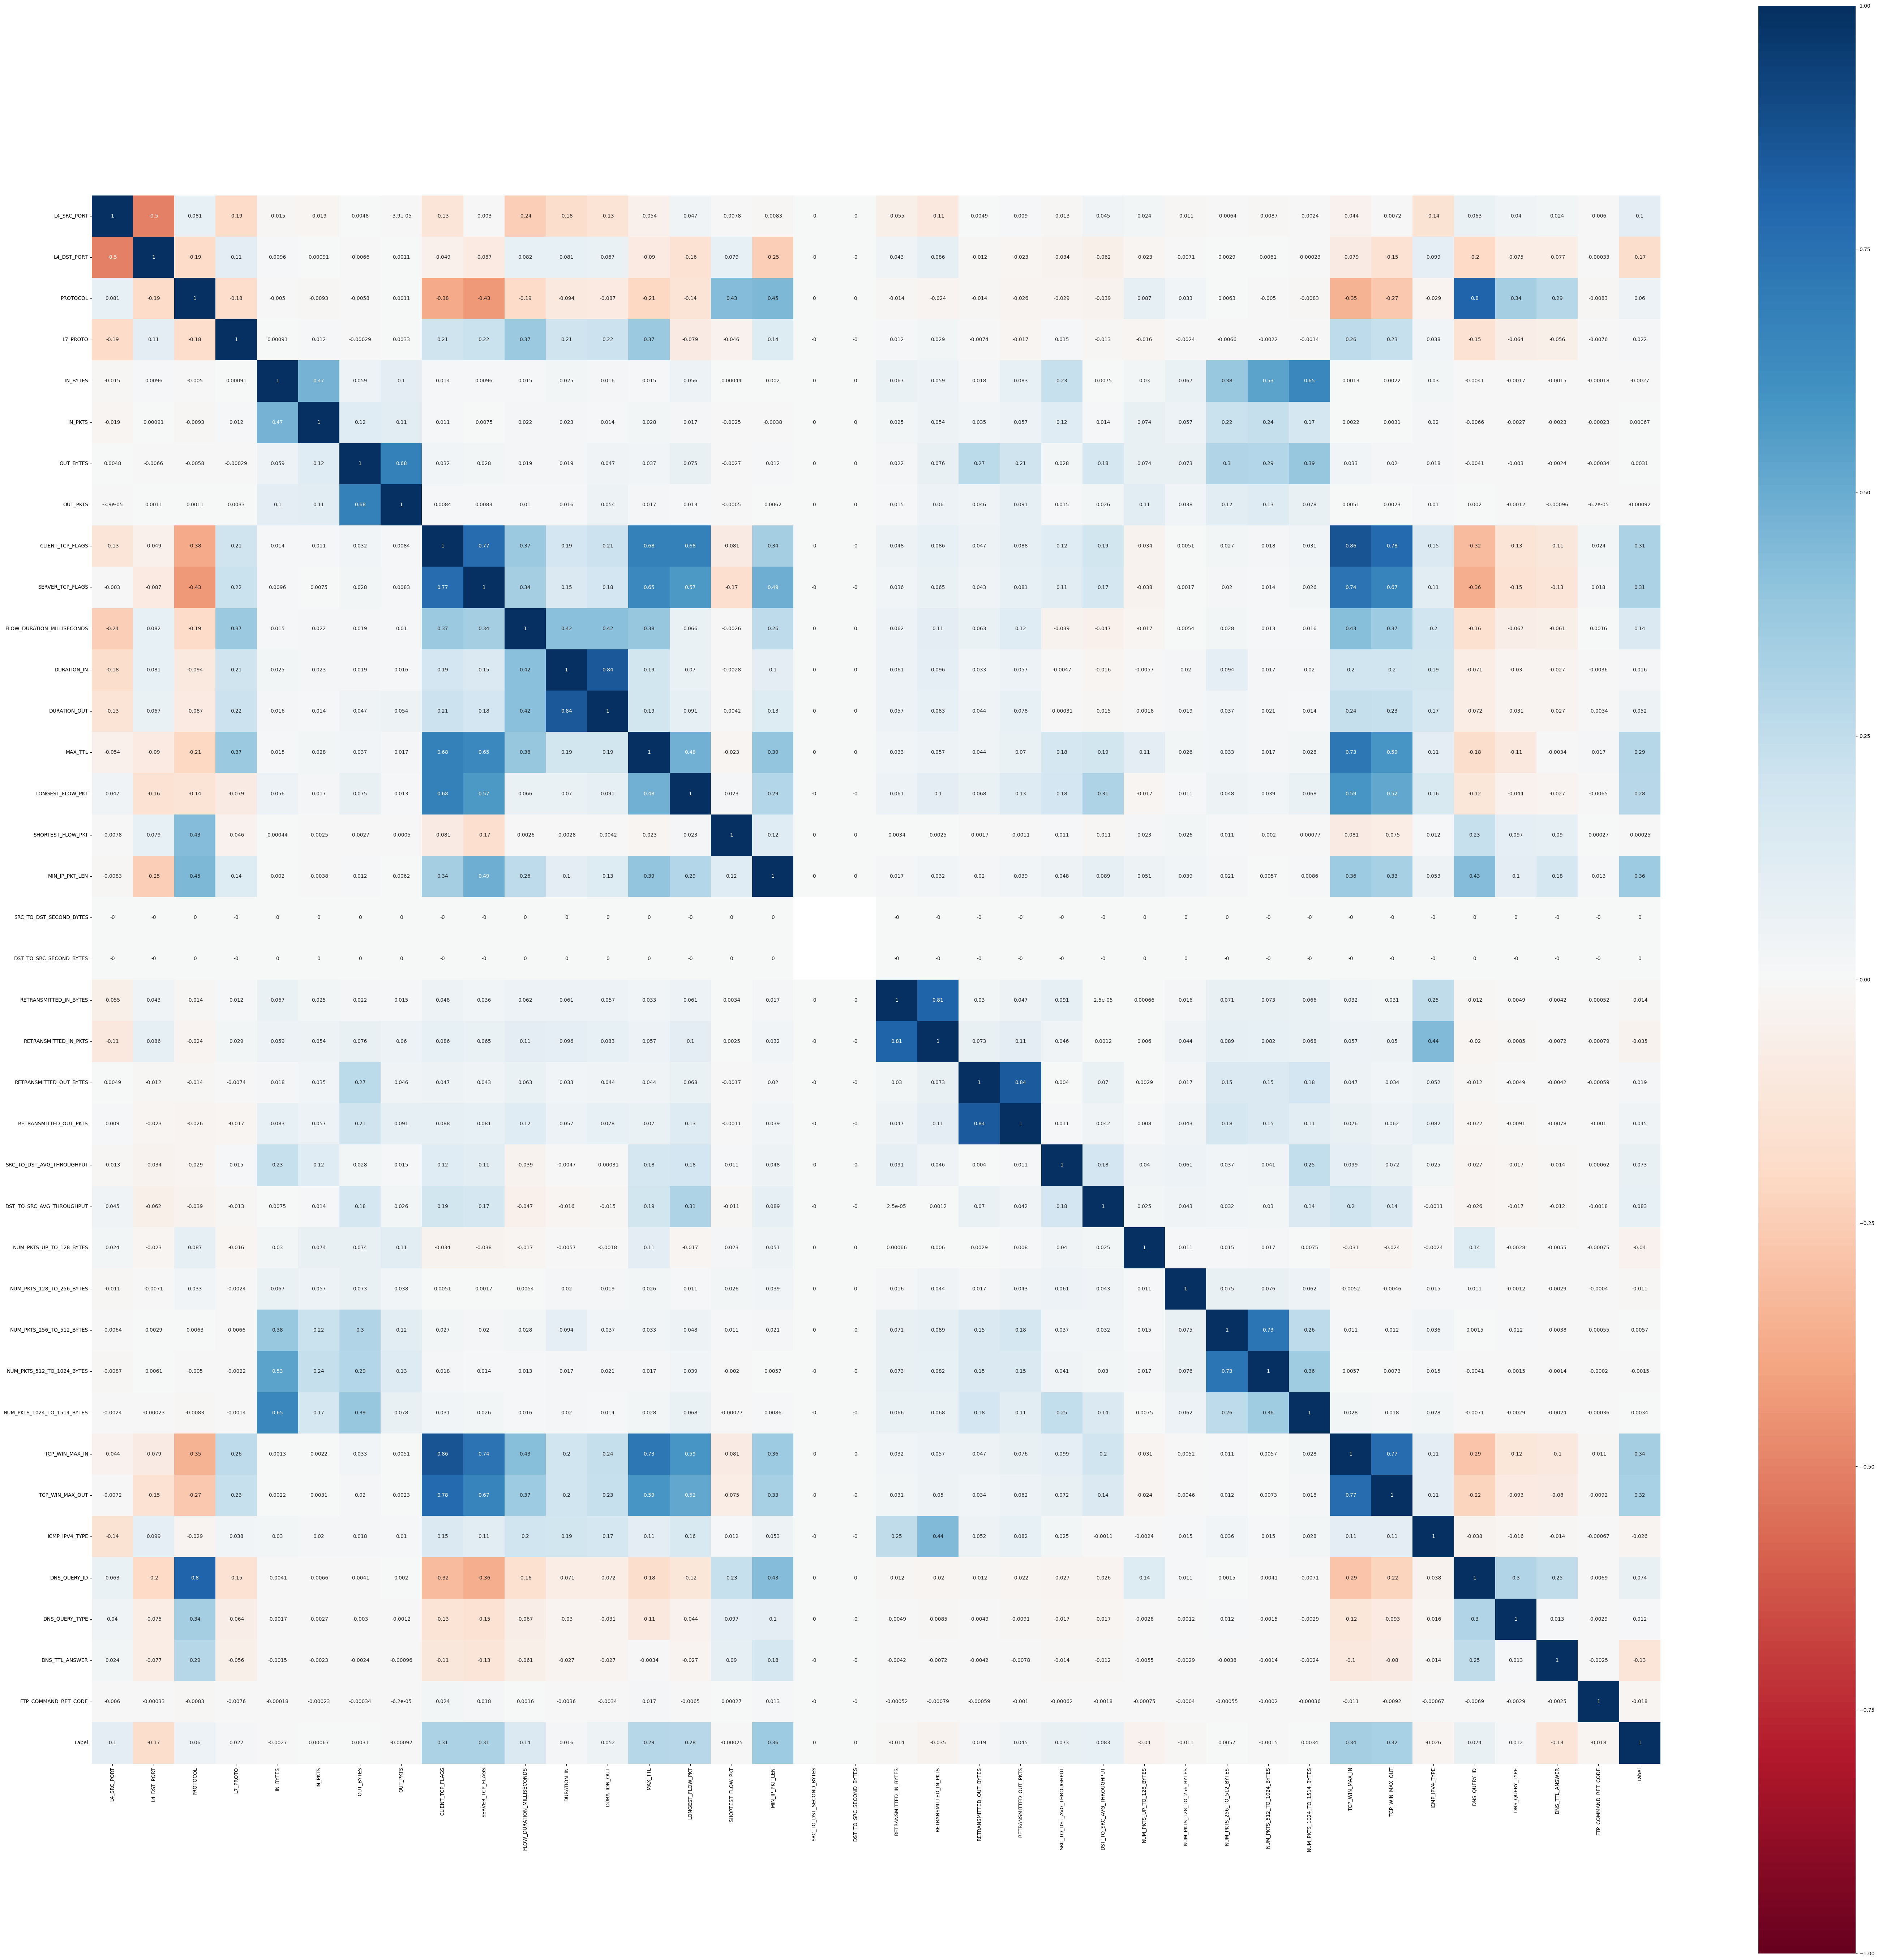

CPU times: user 8.87 s, sys: 398 ms, total: 9.27 s
Wall time: 9.38 s


In [69]:
%%time
# pearson correlation heatmap
plt.figure(figsize=(70, 70))
corr = df_balanced.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, square=True) # annot=True
plt.show()

In [70]:
%%time
correlated_col = set()
is_correlated = [True] * len(corr.columns)
threshold = 0.90
for i in range (len(corr.columns)):
    if(is_correlated[i]):
        for j in range(i):
          if (corr.iloc[i, j] >= threshold) and (is_correlated[j]):
            colname = corr.columns[j]
            is_correlated[j]=False
            correlated_col.add(colname)

print(correlated_col)
print(len(correlated_col))

set()
0
CPU times: user 12.8 ms, sys: 2 ms, total: 14.8 ms
Wall time: 14.7 ms


In [71]:
%%time
df_balanced.drop(correlated_col, axis=1, inplace=True)
print (df_balanced.shape)

(722130, 38)
CPU times: user 61 ms, sys: 417 ms, total: 478 ms
Wall time: 526 ms


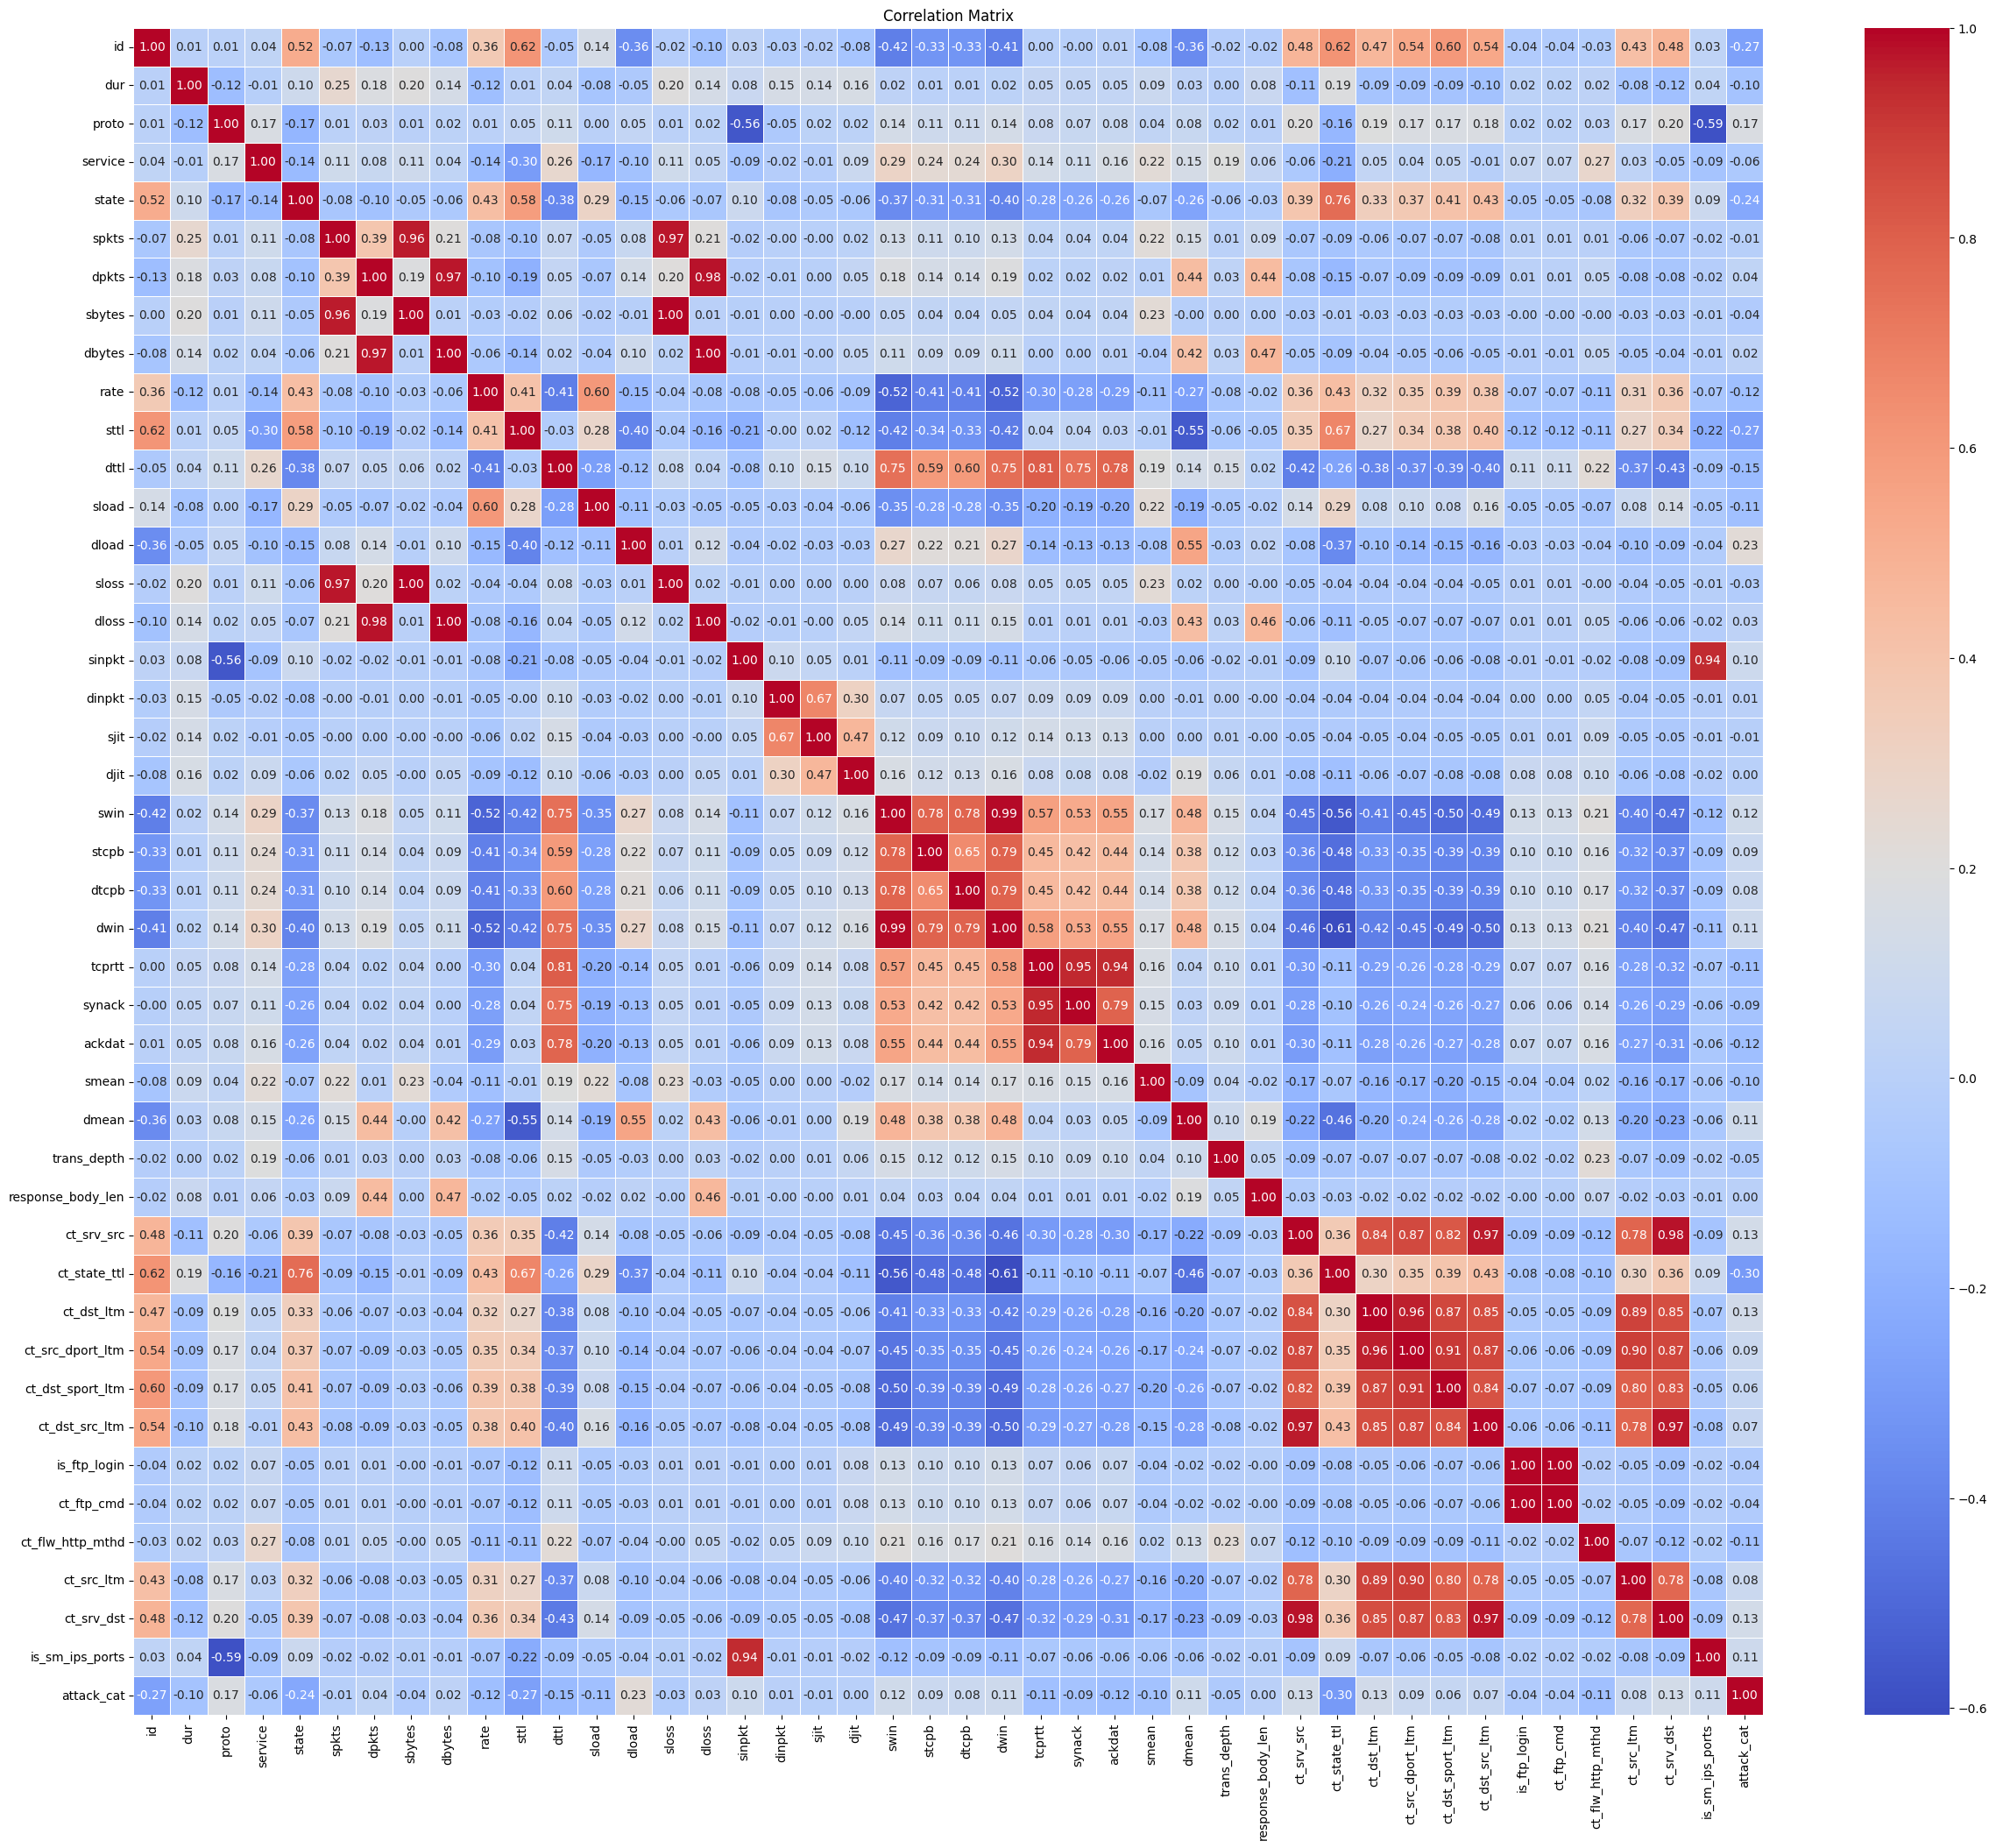

In [73]:
# Calculate correlation matrix
correlation_matrix = df.drop(['label'], axis=1).corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(30, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

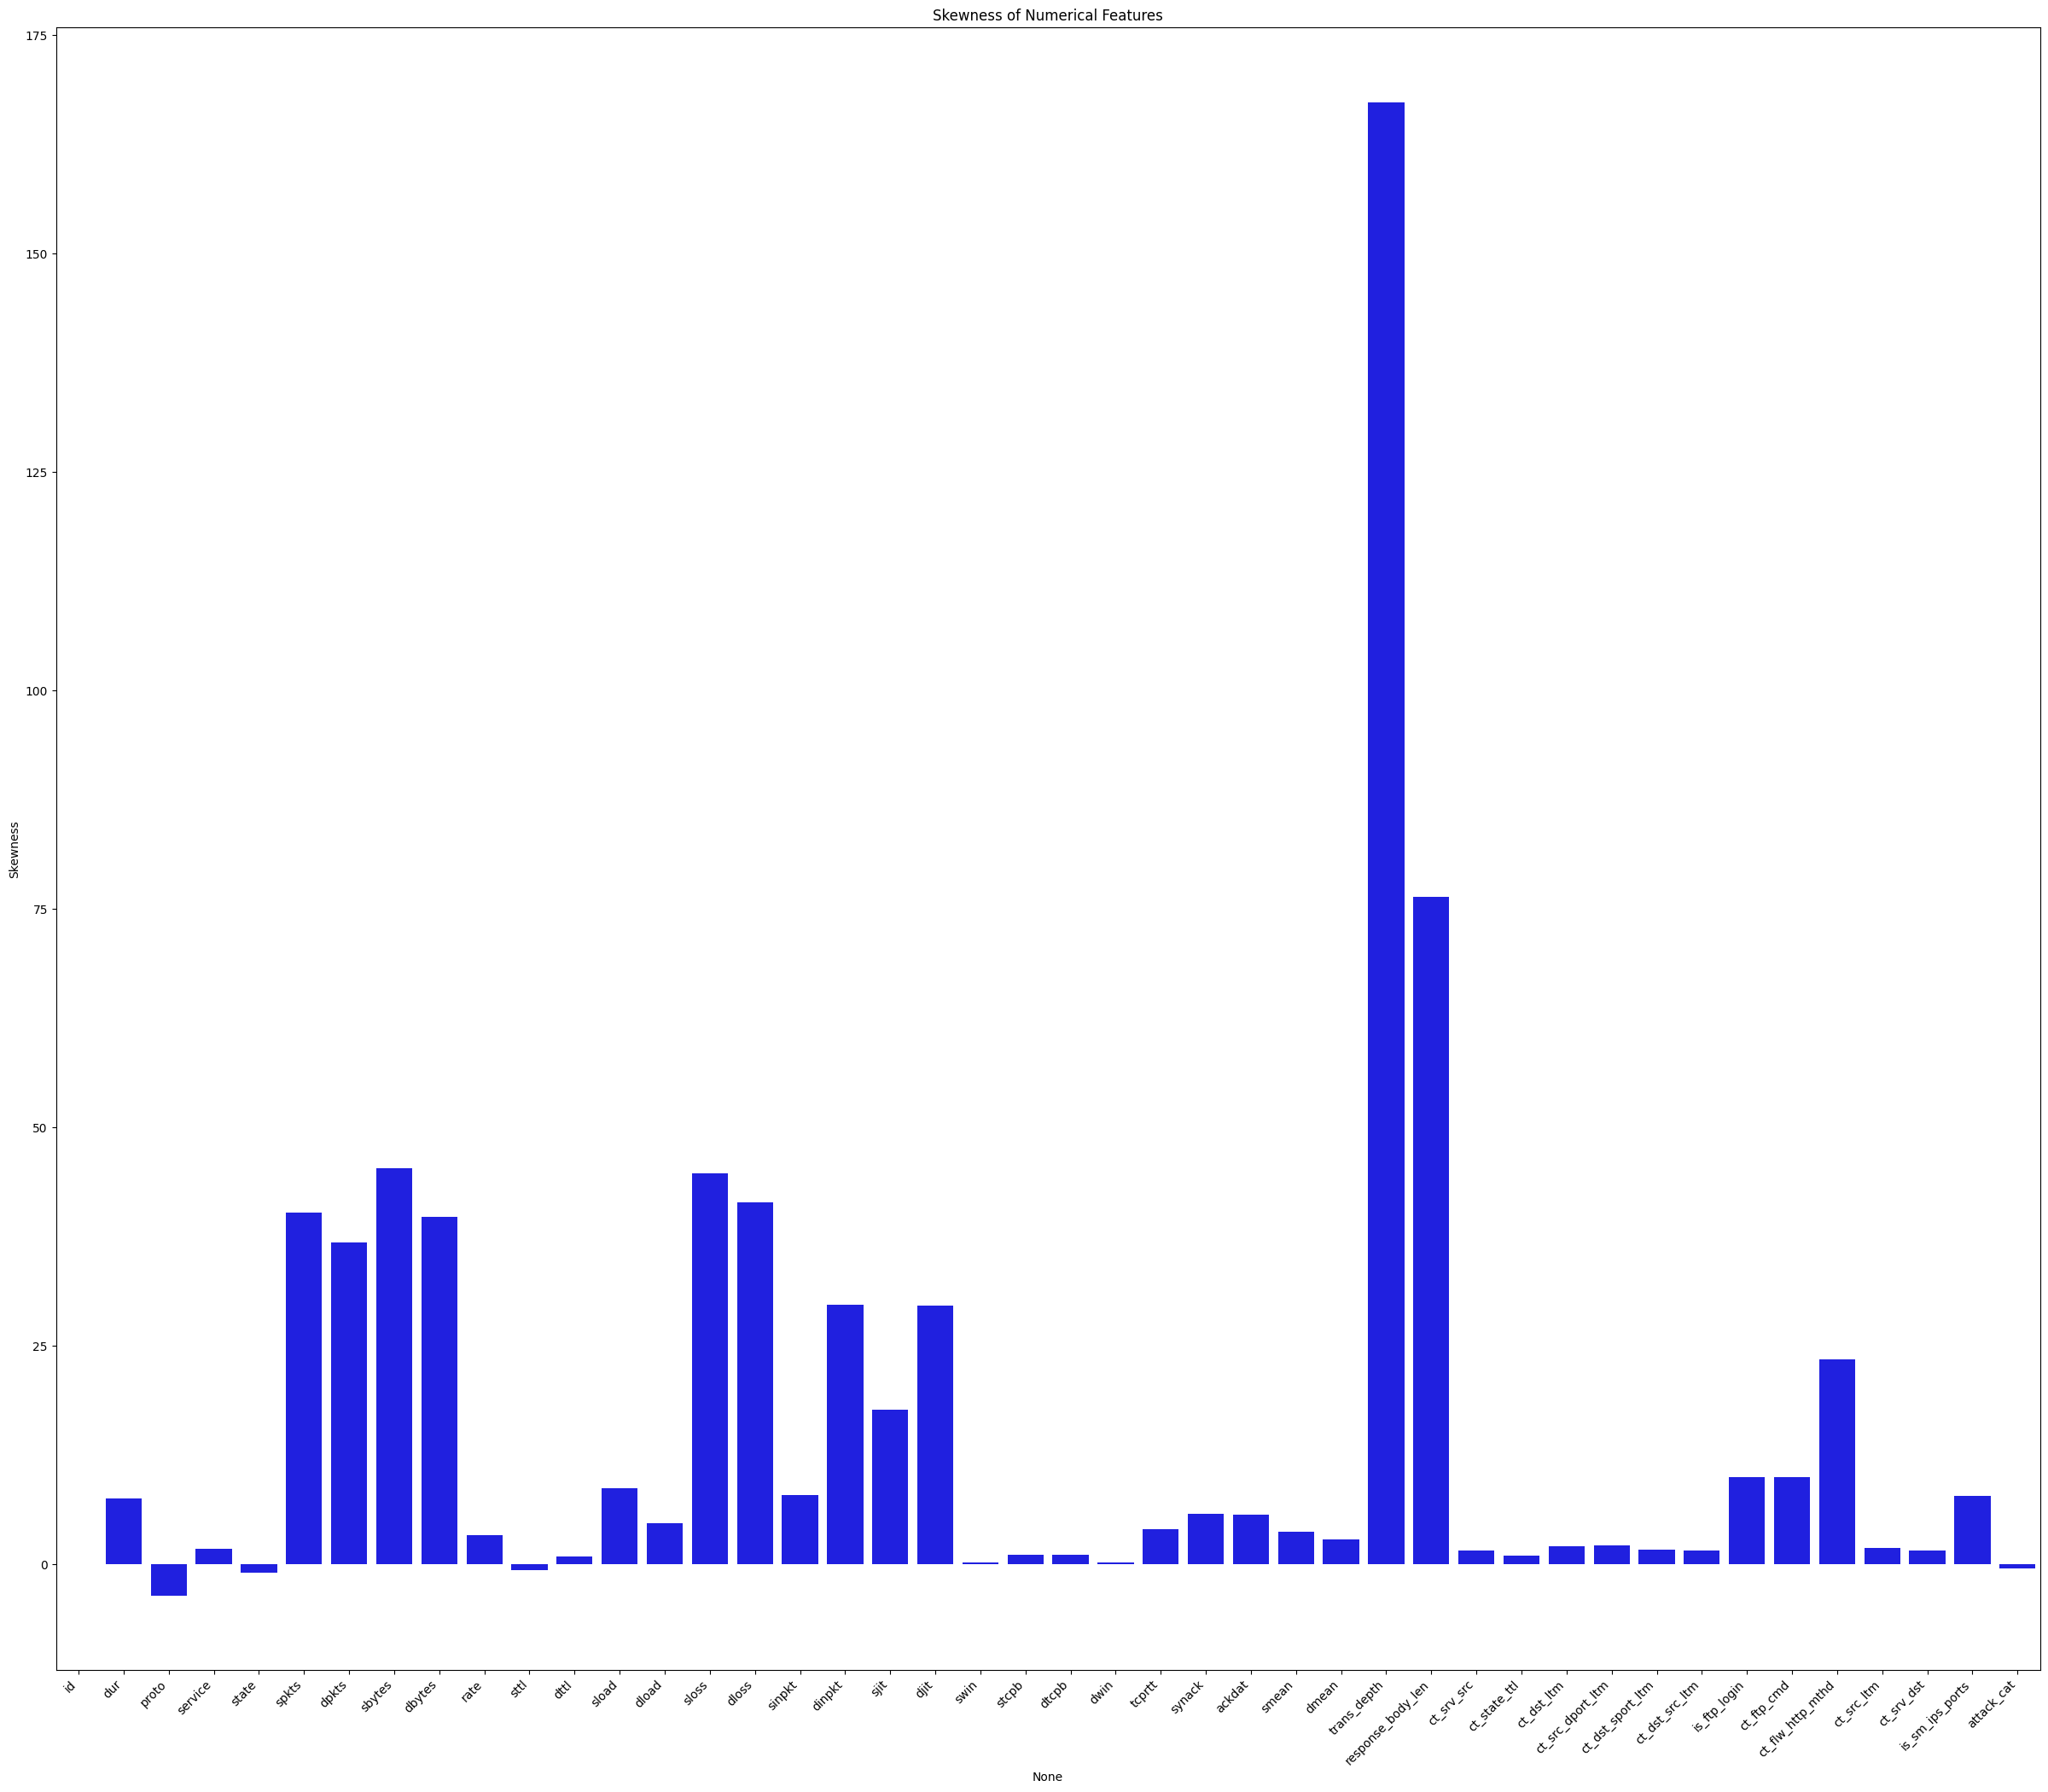

In [74]:
# Calculate skewness for each numerical column
skewness = df.drop(['label'], axis=1).skew()

# Create a bar plot or a histogram of skewness values
plt.figure(figsize=(30, 25))
sns.barplot(x=skewness.index, y=skewness.values, color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Skewness of Numerical Features')
plt.ylabel('Skewness')
plt.show()

In [76]:
X = df.drop('label', axis=1)
y = df['label']

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Perform oversampling
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with oversampled data
final_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='label')], axis=1)

In [78]:
attackcat_counts = final_df['label'].value_counts()
attackcat_counts

,count
label,
0,238682
1,238682


In [79]:
X = final_df.drop('label', axis=1)
y = final_df['label']

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # stratify helps maintain class distribution
)

In [80]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training set
x_train = scaler.fit_transform(x_train)

# Transform the testing set using the same scaler
x_test = scaler.transform(x_test)

In [81]:
print("Before split NaNs in X:", X.isnull().sum().sum())
print("After split NaNs in x_train:", pd.DataFrame(x_train).isnull().sum().sum())

Before split NaNs in X: 0
After split NaNs in x_train: 0


In [82]:
# Initialize the model
# class_weight='balanced' can help with imbalanced data
model_lr = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)

In [83]:
# --- Added code to check for NaNs ---
print("\nChecking for NaNs in x_train before fitting:")
if np.isnan(x_train).any():
    print("NaN values found in x_train.")
    # You can add further inspection, e.g., count NaNs per column (if x_train is a pandas DataFrame)
    # If x_train is a numpy array after scaling, counting NaNs per column is trickier,
    # but you can count total NaNs:
    print(f"Total NaN values in x_train: {np.isnan(x_train).sum()}")
    # If you want to see where they are, you could print a sample of rows with NaNs,
    # but this might be verbose for large datasets.
else:
    print("No NaN values found in x_train.")
# --- End of added code ---


Checking for NaNs in x_train before fitting:
No NaN values found in x_train.


In [84]:
# Train the model
model_lr.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [85]:
# Make predictions
y_pred_lr = model_lr.predict(x_test)
y_pred_proba_lr = model_lr.predict_proba(x_test)[:, 1]

:# **Calculate the Metrics for One Class SVM**

In [86]:
print("--- Logistic Regression ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba_lr))

--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     47737
           1       0.96      0.96      0.96     47736

    accuracy                           0.96     95473
   macro avg       0.96      0.96      0.96     95473
weighted avg       0.96      0.96      0.96     95473

ROC AUC Score:
0.9957576804853674


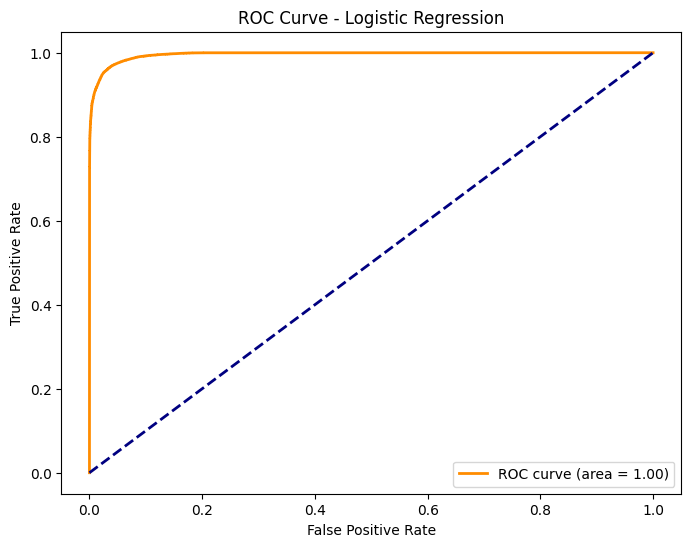

In [87]:
# Plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [88]:
# Calculate the confusion matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Print the confusion matrix
print("Confusion Matrix for Logistic Regression:")
print(conf_matrix_lr)

Confusion Matrix for Logistic Regression:
[[46025  1712]
 [ 1676 46060]]


In [89]:
# Extract TN, FP, FN, TP from the confusion matrix
# The confusion matrix structure for binary classification in sklearn is:
# [[TN, FP],
#  [FN, TP]]
tn, fp, fn, tp = conf_matrix_lr.ravel()

# Print the values
print("\nConfusion Matrix Components:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


Confusion Matrix Components:
True Negatives (TN): 46025
False Positives (FP): 1712
False Negatives (FN): 1676
True Positives (TP): 46060


In [90]:
# Calculate and print the classification report
class_report_svm = classification_report(y_test, y_pred_lr)
print("\nClassification Report for One Class SVM:")
print(class_report_svm)




Classification Report for One Class SVM:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     47737
           1       0.96      0.96      0.96     47736

    accuracy                           0.96     95473
   macro avg       0.96      0.96      0.96     95473
weighted avg       0.96      0.96      0.96     95473



**K-Nearest Neighbour**

In [91]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the model
# Number of neighbors (n_neighbors) is a key hyperparameter
model_knn = KNeighborsClassifier(n_neighbors=5) # Start with 5 neighbors

# Train the model
model_knn.fit(x_train, y_train)

KNeighborsClassifier()

In [92]:
# Make predictions
y_pred_knn = model_knn.predict(x_test)
y_pred_proba_knn = model_knn.predict_proba(x_test)[:, 1]

--- K-Nearest Neighbors ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     47737
           1       1.00      1.00      1.00     47736

    accuracy                           1.00     95473
   macro avg       1.00      1.00      1.00     95473
weighted avg       1.00      1.00      1.00     95473

ROC AUC Score:
0.9998494148232636


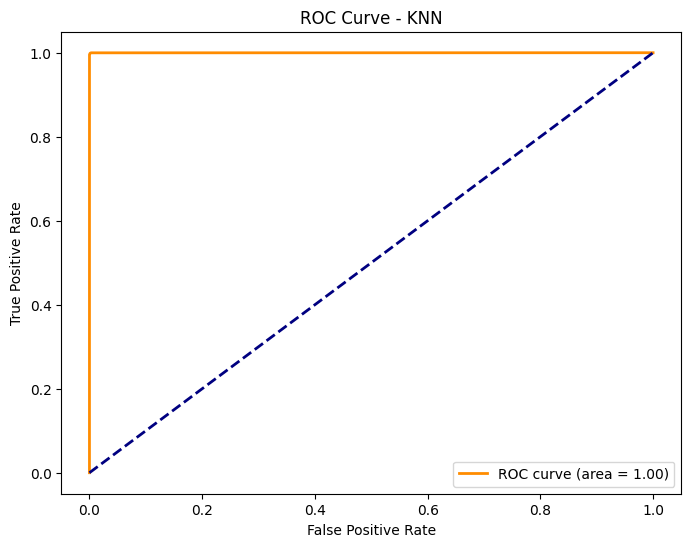

In [93]:
# Evaluate
print("--- K-Nearest Neighbors ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba_knn))
# Plot ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend(loc="lower right")
plt.show()

In [94]:
# Calculate the confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# Print the confusion matrix
print("Confusion Matrix for KNN Neighbour:")
print(conf_matrix_knn)

Confusion Matrix for KNN Neighbour:
[[47689    48]
 [   65 47671]]


In [95]:
# Extract TN, FP, FN, TP from the confusion matrix
# The confusion matrix structure for binary classification in sklearn is:
# [[TN, FP],
#  [FN, TP]]
tn, fp, fn, tp = conf_matrix_knn.ravel()

# Print the values
print("\nConfusion Matrix Components:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


Confusion Matrix Components:
True Negatives (TN): 47689
False Positives (FP): 48
False Negatives (FN): 65
True Positives (TP): 47671


The feature importance code below ran for more than 1 hr 20 min with CPU. Ran the model using CPU, so did not turn on GPU after

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Assuming you have X (features) and y (labels) from your previous steps
# For Isolation Forest, you might need to preprocess y if it's for anomaly detection
# Here, we'll use the existing train/test split for demonstration.

# Permutation Importance for KNN
# Train a KNN model (using your existing x_train, y_train)
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(x_train, y_train)

# Calculate permutation importance
result_knn = permutation_importance(model_knn, x_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Get importance scores and sort them
sorted_idx_knn = result_knn.importances_mean.argsort()

print("Permutation Importance for KNN:")
for i in sorted_idx_knn[::-1]:
    if result_knn.importances_mean[i] > 0:
        print(f"{df_balanced.drop('Label', axis=1).columns[i]:<30}"
              f"{result_knn.importances_mean[i]:.3f}"
              f" +/- {result_knn.importances_std[i]:.3f}")

# Permutation Importance for Isolation Forest
# Isolation Forest is typically used for unsupervised anomaly detection,
# but for demonstration purposes, we'll use the labeled data.
# You might need to adapt this if your Isolation Forest task is strictly unsupervised.
model_if = IsolationForest(random_state=42)
model_if.fit(x_train)

# Calculate permutation importance. You'll need a scoring function
# appropriate for Isolation Forest's output (anomaly scores).
# For demonstration, we'll use a simple custom scoring function
# that checks if the predicted anomaly score indicates an anomaly.
# In a real scenario, you might use a more robust scoring method
# based on thresholding or other anomaly detection metrics.

def anomaly_scoring(estimator, X, y):
    # Isolation Forest decision_function returns negative scores for anomalies
    # We'll treat scores below a threshold (e.g., 0) as anomalies for scoring
    predictions = (estimator.decision_function(X) < 0).astype(int)
    # You can use any relevant metric here, e.g., F1-score if you have ground truth anomalies
    return accuracy_score(y, predictions)


result_if = permutation_importance(model_if, x_test, y_test, n_repeats=10, random_state=42, scoring=anomaly_scoring)

# Get importance scores and sort them
sorted_idx_if = result_if.importances_mean.argsort()

print("\nPermutation Importance for Isolation Forest (using a custom anomaly scoring):")
for i in sorted_idx_if[::-1]:
     if result_if.importances_mean[i] > 0:
        print(f"{df_balanced.drop('Label', axis=1).columns[i]:<30}"
              f"{result_if.importances_mean[i]:.3f}"
              f" +/- {result_if.importances_std[i]:.3f}")

In [ ]:
# prompt: Can you help to draw bar graph for the permuation importance?

import matplotlib.pyplot as plt
# Import necessary library for permutation importance
from sklearn.inspection import permutation_importance
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

# --- Code to draw bar graph for Permutation Importance ---

# Get the feature names
feature_names = df_balanced.drop('Label', axis=1).columns

# Permutation Importance for KNN - Plotting
plt.figure(figsize=(12, 8))
# Filter for positive importances for plotting
positive_importances_knn = result_knn.importances_mean[sorted_idx_knn][result_knn.importances_mean[sorted_idx_knn] > 0]
positive_feature_names_knn = [feature_names[i] for i in sorted_idx_knn[result_knn.importances_mean[sorted_idx_knn] > 0]]
positive_std_knn = result_knn.importances_std[sorted_idx_knn][result_knn.importances_mean[sorted_idx_knn] > 0]

# Sort in descending order for plotting
sorted_positive_idx_knn = positive_importances_knn.argsort()[::-1]
sorted_positive_importances_knn = positive_importances_knn[sorted_positive_idx_knn]
sorted_positive_feature_names_knn = [positive_feature_names_knn[i] for i in sorted_positive_idx_knn]
sorted_positive_std_knn = positive_std_knn[sorted_positive_idx_knn]

plt.bar(sorted_positive_feature_names_knn, sorted_positive_importances_knn, yerr=sorted_positive_std_knn)
plt.xticks(rotation=90)
plt.ylabel('Permutation Importance (Accuracy)')
plt.title('Permutation Importance of Features for KNN')
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

# Permutation Importance for Isolation Forest - Plotting
plt.figure(figsize=(12, 8))
# Filter for positive importances for plotting
positive_importances_if = result_if.importances_mean[sorted_idx_if][result_if.importances_mean[sorted_idx_if] > 0]
positive_feature_names_if = [feature_names[i] for i in sorted_idx_if[result_if.importances_mean[sorted_idx_if] > 0]]
positive_std_if = result_if.importances_std[sorted_idx_if][result_if.importances_mean[sorted_idx_if] > 0]

# Sort in descending order for plotting
sorted_positive_idx_if = positive_importances_if.argsort()[::-1]
sorted_positive_importances_if = positive_importances_if[sorted_positive_idx_if]
sorted_positive_feature_names_if = [positive_feature_names_if[i] for i in sorted_positive_idx_if]
sorted_positive_std_if = positive_std_if[sorted_positive_idx_if]


plt.bar(sorted_positive_feature_names_if, sorted_positive_importances_if, yerr=sorted_positive_std_if)
plt.xticks(rotation=90)
plt.ylabel('Permutation Importance (Anomaly Scoring)')
plt.title('Permutation Importance of Features for Isolation Forest')
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()
